<a href="https://colab.research.google.com/github/fabiocorreaf/Recomenda-oImagens/blob/main/Recomenda%C3%A7%C3%A3oImagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile kaggle.json
{"username":"gilnandersonbaruzzo","key":"f2c2930f8c6e566ac10827b50289b2c3"}

Writing kaggle.json


In [2]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=8b570384254416ddf9597cbb57522178f7c92ed4b2e85ec44cf15c25cb607cc3
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [3]:
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/image

In [4]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [02:58<00:00, 249.20it/s]

Moved 44441 images.


In [5]:
import copy
import joblib
import pathlib
import kagglehub
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

path_save_models = 'models'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cuda


In [6]:
class CustomDataset(Dataset):
    def __init__(self, path_images, labels, transform, transform_augmentation=None):
        self.path_images = path_images
        self.labels = labels
        self.transform = transform
        self.augmentation = transform_augmentation
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.open(self.path_images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.augmentation:
            img = self.augmentation(img)
        else:
            img = self.transform(img)

        return img, torch.tensor(np.array([label]), dtype=torch.float32)


In [7]:

def get_image_path(path):
    X = []
    y = []
    id_to_class = {}
    for cls, folder in enumerate(os.listdir(path)):
        id_to_class[cls] = folder
        full_path = os.path.join(path, folder)
        for filename in os.listdir(full_path):
            if filename.endswith(('jpg', 'png')):  # Melhor prática para verificar múltiplas extensões
                X.append(os.path.join(full_path, filename))
                y.append(cls)
    return X, y, id_to_class

# Definição do caminho dos dados
path_train = '/content/Fashion_data/categories'
path_save_models = "/content/models"

# Criar diretório de salvamento caso não exista
os.makedirs(path_save_models, exist_ok=True)

# Obter caminhos das imagens e rótulos
X_train, y_train, id_to_class = get_image_path(path_train)

# Aplicar One-Hot Encoding nos rótulos
one_hot = OneHotEncoder(sparse_output=False)
y_train = one_hot.fit_transform(np.array(y_train).reshape(-1, 1))

# Salvar o encoder treinado
joblib.dump(one_hot, os.path.join(path_save_models, 'oneHot_fashion.joblib'))

# Dividir os dados em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

# Exibir o mapeamento das classes
id_to_class



{0: 'Apparel',
 1: 'Home',
 2: 'Sporting Goods',
 3: 'Footwear',
 4: 'Personal Care',
 5: 'Free Items',
 6: 'Accessories'}

In [8]:
pd.DataFrame.from_dict(id_to_class, orient='index').to_csv(f'{path_save_models}/id_to_class_fashion.csv', header=None)

print(one_hot.transform([[0]]))
print(one_hot.transform([[1]]))
print(one_hot.transform([[2]]))


[[1. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0.]]


In [9]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
model

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(one_hot.transform([[0]])[0]))
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 209MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

transform_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])


In [11]:
dataset_train = CustomDataset(X_train, y_train, transform_default, transform_augmentation)
dataset_valid = CustomDataset(X_valid, y_valid, transform_default)

train_loader = torch.utils.data.DataLoader(
                    dataset_train, batch_size=32,
                    shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)

valid_loader = torch.utils.data.DataLoader(
                dataset_valid, batch_size=32,
                shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

In [12]:
log_name = ''
dataset_name = 'fashion'
total_epoch = 1


if log_name != '':
    writer = SummaryWriter(f'runs/{log_name}')  # 'runs/50'
else:
    writer = SummaryWriter()

results = []
# acc, loss, epoch
best_acc = [0., 0., 0]

for epoch in range(total_epoch):
    torch.cuda.empty_cache()
    model.train()
    running_loss = 0.
    running_accuracy = 0.
    running_p = []
    running_y = []
    for data in tqdm(train_loader):
        inputs, labels = data
        labels = labels.squeeze(1)

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(torch.softmax(outputs, dim=1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcule accuracy
        outputs = outputs.cpu().detach()
        labels = labels.cpu().detach()
        output_probs, top_class_output = outputs.topk(k = 1, dim = 1)
        label_probs, top_class_label = labels.topk(k = 1, dim = 1)
        running_accuracy += accuracy_score(top_class_label, top_class_output)
    writer.add_scalar(f'{dataset_name}-Accuracy/train', running_accuracy/len(train_loader), epoch)
    writer.add_scalar(f'{dataset_name}-Loss/train', running_loss/len(train_loader), epoch)
    print('Epoch {}; Loss {}; Accuracy {}'.format(epoch, running_loss/len(train_loader), running_accuracy/len(train_loader)))

    if epoch % 1 == 0:
        model.eval()
        running_accuracy_valid = 0.
        running_loss_valid = 0.
        running_p2 = []
        running_y2 = []
        for data in tqdm(valid_loader):
            inputs_valid, labels_valid = data
            labels_valid = labels_valid.squeeze(1)

            inputs_valid = inputs_valid.to(device)
            labels_valid = labels_valid.to(device)

            outputs_valid = model(inputs_valid)
            loss = criterion(torch.softmax(outputs_valid, dim=1), labels_valid)
            running_loss_valid += loss.item()

            # Calcule accuracy
            outputs_valid = outputs_valid.cpu().detach()
            labels_valid = labels_valid.cpu().detach()
            output_valid_probs, top_class_output = outputs_valid.topk(k = 1, dim = 1)
            label_probs_valid, top_class_label = labels_valid.topk(k = 1, dim = 1)
            running_accuracy_valid += accuracy_score(top_class_label, top_class_output)
        writer.add_scalar(f'{dataset_name}-Accuracy/valid', running_accuracy_valid/len(valid_loader), epoch)
        writer.add_scalar(f'{dataset_name}-Loss/valid', running_loss_valid/len(valid_loader), epoch)
        print(f'Loss valid {running_loss_valid/len(valid_loader)}; Accuracy valid:{running_accuracy_valid/len(valid_loader)}')
        if running_accuracy_valid/len(valid_loader) > best_acc[0]:
            print('### New best model! ###')
            best_acc = [running_accuracy_valid/len(valid_loader), running_loss_valid/len(valid_loader), epoch]
            best_model = copy.deepcopy(model)
    writer.flush()
writer.flush()


  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 0; Loss 0.010631860080077079; Accuracy 0.954864443378119


  0%|          | 0/348 [00:00<?, ?it/s]

Loss valid 0.004503435597683847; Accuracy valid:0.9818991174055829
### New best model! ###


In [13]:
pathlib.Path(path_save_models).mkdir(exist_ok=True, parents=True)
torch.save(best_model, f'{path_save_models}/fashion.pth')

In [14]:
best_model = torch.load(f'{path_save_models}/fashion.pth')
one_hot = joblib.load(f'{path_save_models}/oneHot_fashion.joblib')
id_to_class = pd.read_csv(f'{path_save_models}/id_to_class_fashion.csv', index_col=0, header=None)[1].T.to_dict()

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

<ipython-input-14-8842fe5d4606>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f'{path_save_models}/fashion.pth')


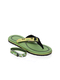

In [15]:
idx = 0
img = Image.open(X_valid[idx]).convert('RGB')
img


In [16]:
input_data = transform_default(img).unsqueeze(0).to(device)
output = best_model(input_data)
output_softmax = torch.softmax(output, dim=1)
output_valid_probs, top_class_output = output_softmax.topk(k = 1, dim = 1)
label_probs_valid, top_class_label = torch.Tensor(y_valid[idx]).unsqueeze(0).topk(k = 1, dim = 1)
print(f'Real: {top_class_label[0][0]}-{id_to_class[int(top_class_label[0][0])]}' +
      f' - pred_class: {top_class_output[0][0]}-{id_to_class[int(top_class_output[0][0])]}' +
      f'\nPred_prob: {output_softmax}')

Real: 3-Footwear - pred_class: 3-Footwear
Pred_prob: tensor([[4.2716e-05, 2.4017e-03, 3.1341e-03, 9.8355e-01, 7.2292e-03, 2.2765e-03,
         1.3653e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [17]:
pred = []
for data in tqdm(X_valid):
    img = Image.open(data).convert('RGB')
    input_data = transform_default(img).unsqueeze(0).to(device)
    output = best_model(input_data)
    result = torch.softmax(output, dim=1).cpu().detach()
    pred.append(result)

  0%|          | 0/11111 [00:00<?, ?it/s]

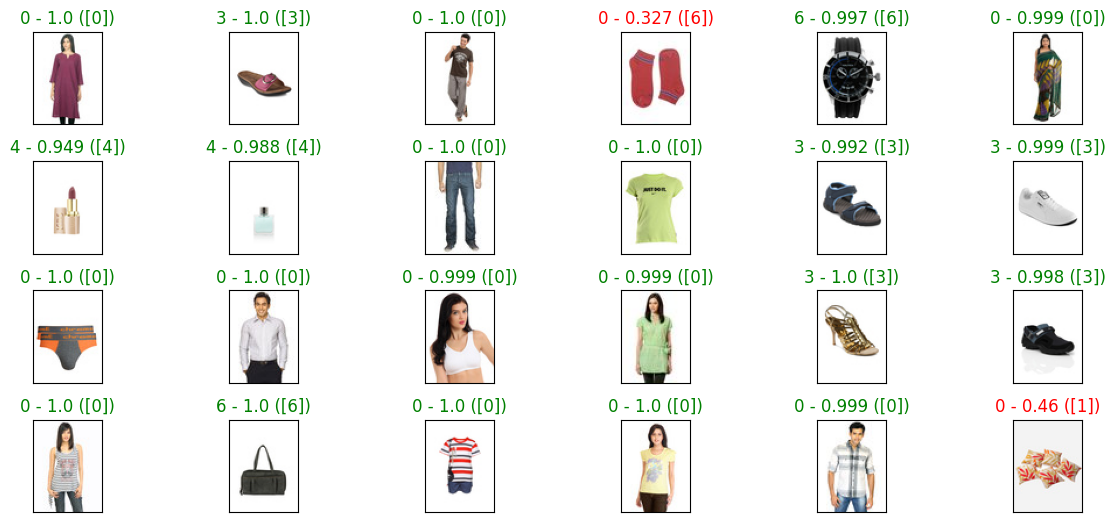

In [18]:
num_x = 6
num_y = 4
fig = plt.figure(figsize=(num_y, num_x))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
fig.set_figheight(6)
fig.set_figwidth(14)
y = one_hot.inverse_transform(y_valid)
for i, idx in enumerate(np.random.choice((len(X_valid)), size=num_x*num_y, replace=False)):
    ax = fig.add_subplot(num_y, num_x, i + 1, xticks=[], yticks=[])
    ax.imshow(Image.open(X_valid[idx]).convert('RGB'))
    top_prob, top_class = pred[idx].topk(k = 1, dim = 1)
    ax.set_title("{} - {} ({})".format(int(top_class[0][0]), round(float(top_prob), 3), y[idx]),
                 color=("green" if int(top_class[0][0]) == y[idx] else "red"))

Accuracy: 0.982179821798218


<Axes: >

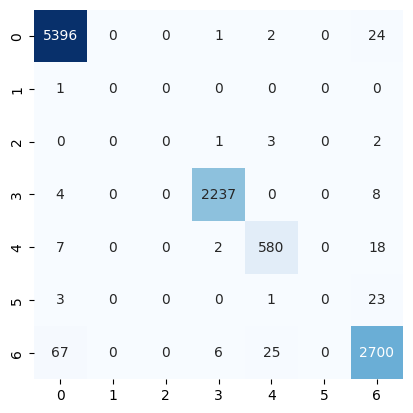

In [19]:
top_probs, top_classes = torch.cat(pred).topk(k = 1, dim = 1)
conf_matrix = confusion_matrix(one_hot.inverse_transform(y_valid), top_classes)
print(f'Accuracy: {accuracy_score(one_hot.inverse_transform(y_valid), top_classes)}')
sns.heatmap(conf_matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)


In [20]:
import os
model_path = '/content/drive/MyDrive/models'
os.makedirs(model_path, exist_ok=True)

# Salva o modelo treinado (apenas o state_dict)
# import torch
# torch.save(best_model.state_dict(), os.path.join(model_path, 'fashion_model.pth'))

# Ou, se preferir, salve o modelo completo
torch.save(best_model, os.path.join(model_path, 'fashion_model_full.pth'))


In [21]:
# ===============================================
# SISTEMA DE RECOMENDAÇÃO POR SIMILARIDADE DE IMAGEM
# ===============================================

import requests
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity

def extract_embedding(image, model, transform, device):
    """
    Dada uma imagem PIL, extrai o vetor de features usando a parte
    de extração de features do modelo (até a camada de pooling).
    """
    model.eval()
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        # Para EfficientNet, usamos as camadas de features e avgpool:
        features = model.features(input_tensor)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
    return features.cpu().numpy().flatten()

# 1. Construir o banco de embeddings para as imagens do dataset
print("Extraindo embeddings das imagens do dataset (X_valid)...")
dataset_embeddings = []
# Vamos usar as imagens de validação (X_valid) – você pode usar outro conjunto se preferir.
for path in tqdm(X_valid, desc="Extraindo embeddings"):
    try:
        img = Image.open(path).convert('RGB')
        emb = extract_embedding(img, best_model, transform_default, device)
        dataset_embeddings.append(emb)
    except Exception as e:
        print(f"Erro ao processar {path}: {e}")
dataset_embeddings = np.array(dataset_embeddings)
print(f"Embeddings extraídos para {len(dataset_embeddings)} imagens.")

Extraindo embeddings das imagens do dataset (X_valid)...


Extraindo embeddings:   0%|          | 0/11111 [00:00<?, ?it/s]

Embeddings extraídos para 11111 imagens.


Baixando imagem de consulta de: https://loja.comerciomix.com.br/media/catalog/product/cache/fb4f878514d02efd710032ded901d118/c/a/camiseta-azul-royal-para-sublima_o-tradicional_1.jpg


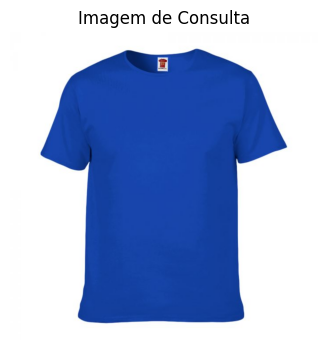

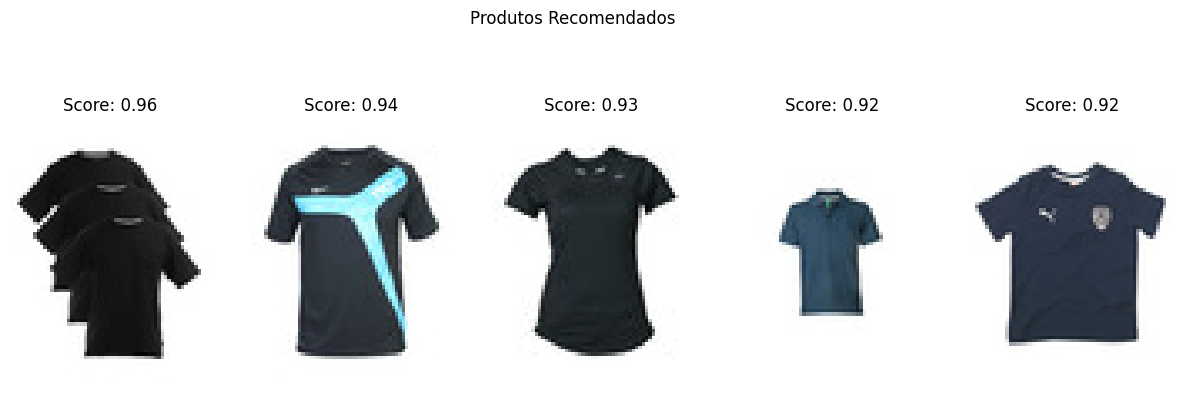

In [22]:

# 2. Carregar uma imagem de consulta a partir de uma URL
# Substitua 'https://example.com/sua_imagem.jpg' pela URL da imagem desejada.
query_url = "https://loja.comerciomix.com.br/media/catalog/product/cache/fb4f878514d02efd710032ded901d118/c/a/camiseta-azul-royal-para-sublima_o-tradicional_1.jpg"
print(f"Baixando imagem de consulta de: {query_url}")
response = requests.get(query_url)
query_img = Image.open(BytesIO(response.content)).convert('RGB')

# Exibir a imagem de consulta
plt.figure(figsize=(4,4))
plt.imshow(query_img)
plt.title("Imagem de Consulta")
plt.axis('off')
plt.show()

# 3. Extrair o embedding da imagem de consulta
query_embedding = extract_embedding(query_img, best_model, transform_default, device)

# 4. Calcular a similaridade (utilizando similaridade cosseno) entre a imagem de consulta e todas do dataset
similarities = cosine_similarity(query_embedding.reshape(1, -1), dataset_embeddings)
similarities = similarities.flatten()

# 5. Selecionar os top-k produtos recomendados (por exemplo, os 5 mais semelhantes)
top_k = 5
top_indices = similarities.argsort()[-top_k:][::-1]

# 6. Exibir os produtos recomendados com suas similaridades
plt.figure(figsize=(15, 5))
for i, idx in enumerate(top_indices):
    recommended_img = Image.open(X_valid[idx]).convert('RGB')
    sim_score = similarities[idx]
    plt.subplot(1, top_k, i+1)
    plt.imshow(recommended_img)
    plt.title(f"Score: {sim_score:.2f}")
    plt.axis('off')
plt.suptitle("Produtos Recomendados")
plt.show()

Baixando imagem de consulta de: https://static.topper.com.br/produtos/chuteira-society-infantil-topper-forza-ii/76/D30-5887-976/D30-5887-976_zoom1.jpg?ts=1694585877&ims=544x


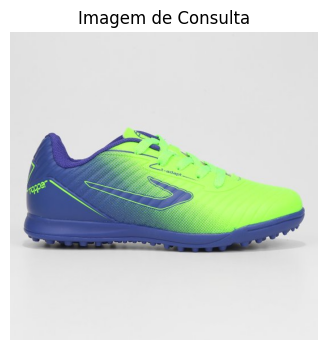

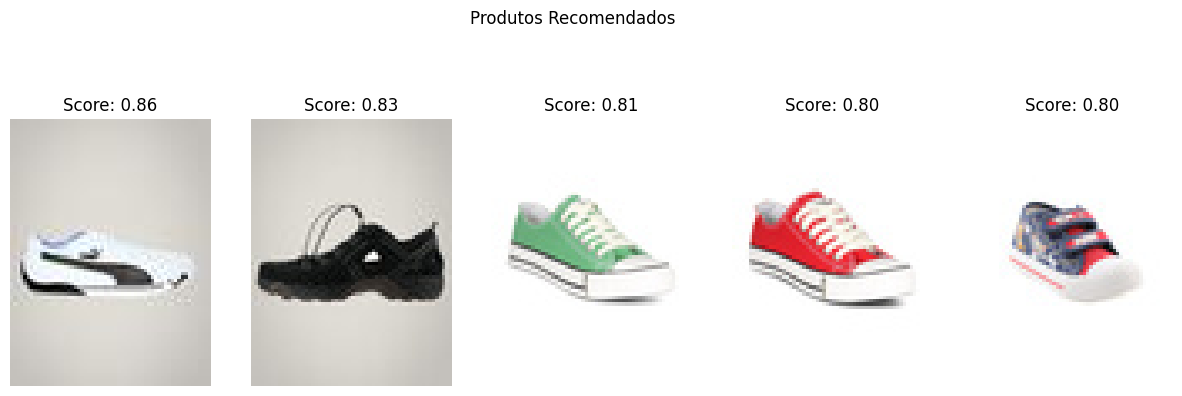

In [23]:

# 2. Carregar uma imagem de consulta a partir de uma URL
# Substitua 'https://example.com/sua_imagem.jpg' pela URL da imagem desejada.
query_url = "https://static.topper.com.br/produtos/chuteira-society-infantil-topper-forza-ii/76/D30-5887-976/D30-5887-976_zoom1.jpg?ts=1694585877&ims=544x"
print(f"Baixando imagem de consulta de: {query_url}")
response = requests.get(query_url)
query_img = Image.open(BytesIO(response.content)).convert('RGB')

# Exibir a imagem de consulta
plt.figure(figsize=(4,4))
plt.imshow(query_img)
plt.title("Imagem de Consulta")
plt.axis('off')
plt.show()

# 3. Extrair o embedding da imagem de consulta
query_embedding = extract_embedding(query_img, best_model, transform_default, device)

# 4. Calcular a similaridade (utilizando similaridade cosseno) entre a imagem de consulta e todas do dataset
similarities = cosine_similarity(query_embedding.reshape(1, -1), dataset_embeddings)
similarities = similarities.flatten()

# 5. Selecionar os top-k produtos recomendados (por exemplo, os 5 mais semelhantes)
top_k = 5
top_indices = similarities.argsort()[-top_k:][::-1]

# 6. Exibir os produtos recomendados com suas similaridades
plt.figure(figsize=(15, 5))
for i, idx in enumerate(top_indices):
    recommended_img = Image.open(X_valid[idx]).convert('RGB')
    sim_score = similarities[idx]
    plt.subplot(1, top_k, i+1)
    plt.imshow(recommended_img)
    plt.title(f"Score: {sim_score:.2f}")
    plt.axis('off')
plt.suptitle("Produtos Recomendados")
plt.show()

Baixando imagem de consulta de: https://images.tcdn.com.br/img/img_prod/592274/colar_de_prata_ponto_de_luz_827_1_9ae01a33a42e39c368fa4582d0c1e537.jpg


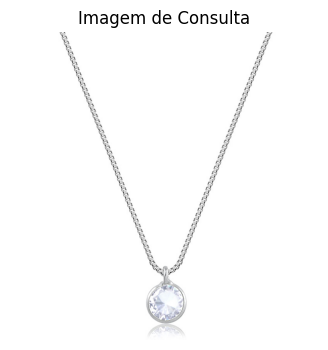

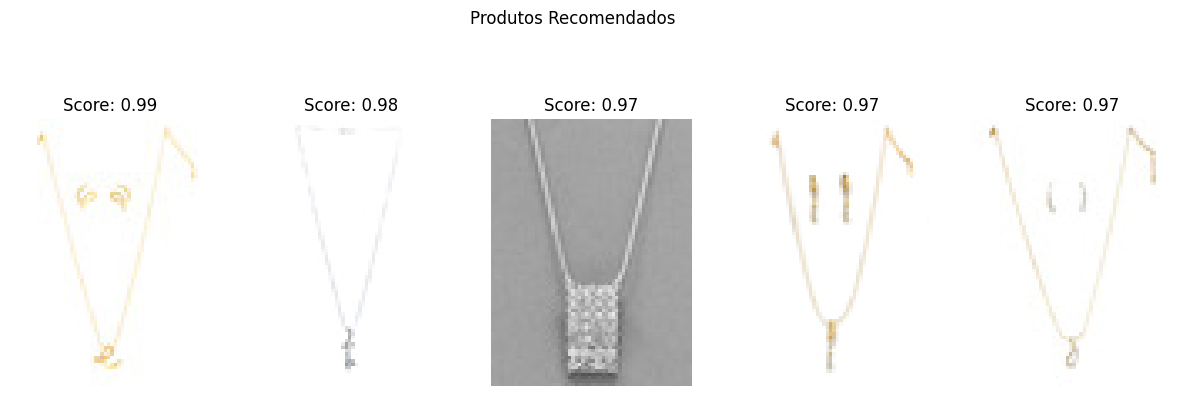

In [25]:

# 2. Carregar uma imagem de consulta a partir de uma URL
# Substitua 'https://example.com/sua_imagem.jpg' pela URL da imagem desejada.
query_url = "https://images.tcdn.com.br/img/img_prod/592274/colar_de_prata_ponto_de_luz_827_1_9ae01a33a42e39c368fa4582d0c1e537.jpg"
print(f"Baixando imagem de consulta de: {query_url}")
response = requests.get(query_url)
query_img = Image.open(BytesIO(response.content)).convert('RGB')

# Exibir a imagem de consulta
plt.figure(figsize=(4,4))
plt.imshow(query_img)
plt.title("Imagem de Consulta")
plt.axis('off')
plt.show()

# 3. Extrair o embedding da imagem de consulta
query_embedding = extract_embedding(query_img, best_model, transform_default, device)

# 4. Calcular a similaridade (utilizando similaridade cosseno) entre a imagem de consulta e todas do dataset
similarities = cosine_similarity(query_embedding.reshape(1, -1), dataset_embeddings)
similarities = similarities.flatten()

# 5. Selecionar os top-k produtos recomendados (por exemplo, os 5 mais semelhantes)
top_k = 5
top_indices = similarities.argsort()[-top_k:][::-1]

# 6. Exibir os produtos recomendados com suas similaridades
plt.figure(figsize=(15, 5))
for i, idx in enumerate(top_indices):
    recommended_img = Image.open(X_valid[idx]).convert('RGB')
    sim_score = similarities[idx]
    plt.subplot(1, top_k, i+1)
    plt.imshow(recommended_img)
    plt.title(f"Score: {sim_score:.2f}")
    plt.axis('off')
plt.suptitle("Produtos Recomendados")
plt.show()